# Project proposal

##### Submitted by Tal Rave and Assaf Goren

### The problem: face detection and clustering 

We would like to create a program that detects, aligns and crops faces from images, and clusters them.<br><br>
A quick reminder:<br><br>
In our presentation we showed a simple program that clusters images of faces taken from a small dataset, by using simple "hand-crafted" features (e.g. HOG features) and hierarchical clustering (we used the number of individuals as input) - we would like to take this idea a few steps forward; we will use larger datasets of images taken "in-the-wild" (hence the need to detect, align and crop), and use clustering methods that are distance\density-based so that we will not need to input the number of individuals in the test set, thus making the aforementioned problem much more challenging.



### Motivation:

Given a dataset of unlabeled images of people, our algorithm would (hopefully) be able to distinguish between the detected faces and cluster them accordingly. The main use\motivation is human surveillance. Imagine having cameras spread out in many different areas\locations, which accumulate images of faces and periodically send them to some data center. Assume that (ideally) all images of a person's face are placed in a unique cluster. We know where that person was and when (where and when his\her photos were taken), and so we can get a good estimate of the exact route that that person took.     

### Data:

There are several datasets that we can use (obviously, we need a large labeled dataset that contains several images of the same person for every\most persons in the dataset):<br>

1. http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html (The non-aligned version).
2. http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/ (This is an exceptionally large dataset, but we can use only a subset if necessary).
3. https://scikit-learn.org/0.19/datasets/olivetti_faces.html (This is the small dataset that we used in the presentation. It might be interesting to use it as one of the test sets).<br>

### Methods:

The project will be composed of 3 main parts\stages:
1. Data preparation (grayscale conversion, detection, alignment, cropping and cleaning\removing incorrect crops).
2. Supervised learning (learning to generate useful image representations that help distinguish between images of faces of different individuals).
3. Unsupervised learning (clustering the image representations that were generated in the previous stage).

We intend to try the following methods:<br><br>
Stage 1:<br><br>
Convert to grayscale, use Viola-Jones algorithm (Haar-like features) to detect faces, detect eyes
in the face rectangle (also using Viola-Jones), align the face by rotating the image about the midpoint of the eye rectangles' centers by the appropriate angle, resize the image appropriately, and finally, crop the face.<br><br>
Stage 2:<br><br>
As we implied previously, we need a system that receives a face image as input, and outputs a point in n-dimensional space such that face images of the same person would be transformed into points that are near each other and far from all points that are derived from face images of other individuals - this will make clustering much more effective.<br>
We intend to use a CNN to obtain such representations, by using the triplet loss function (you can read about it here https://en.wikipedia.org/wiki/Triplet_loss). There are implementations of such neural networks available online, but we decided to take the extra step and implement our own modest version.<br><br>
Stage 3:<br><br>
This stage is relatively straightforward. We need to pick a distance\density-based clustering algorithm (e.g. DBSCAN), since we do not know the exact number of individuals\clusters in advance. Additionally, we might use t-SNE on the feature vectors returned by the CNN and apply the clustering algorithm on its output (e.g. clustering 2-dimensional points) - maybe we can get better results this way.<br><br>

### Tools:

We installed TensorFlow (the GPU version). We will use Keras to implement the CNN.
Most of the other tools we will use are provided by OpenCV and sklearn libraries.

## Here are some preliminary results of the data preparation stage:

### Creating and drawing some normalized images:

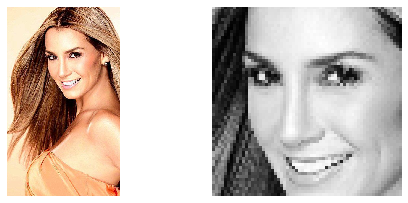

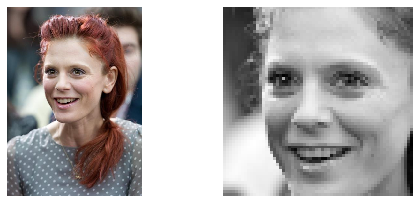

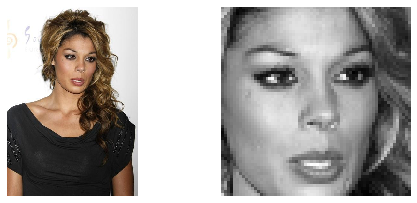

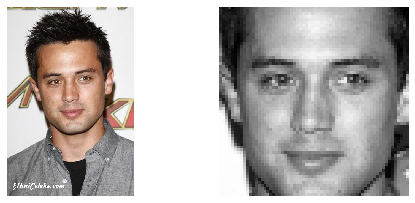

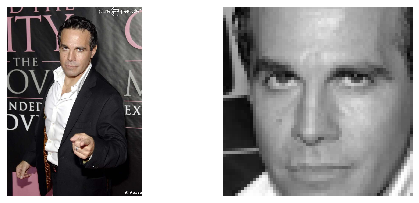

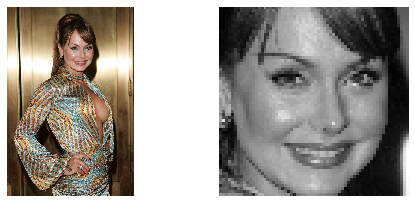

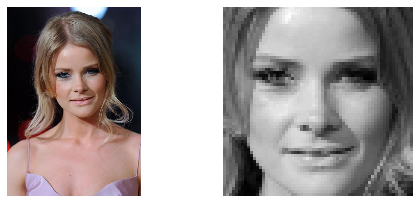

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

# This method receives an image of a person, and returns 
# a normalized version (converts to grayscale, detects the face and eyes, aligns using the eyes center points, 
# crops the face and resizes to the size given as input)
def normalizeImage(img, size):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.3, 5) # detect face
    if len(faces) != 1: # we expect to detect exactly one face per image
        return None
    (x,y,w,h) = faces[0]
    roi = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi, 1.3, 5) # detect the eyes
    ePts = [np.array([x+ex+ew/2,y+ey+eh/2]) for (ex,ey,ew,eh) in eyes]
    if len(ePts) != 2: # we expect to detect exactly two eyes
        return None
    if ePts[0][0] > ePts[1][0]: # make sure that the left eye center is the first point
        ePts[0], ePts[1] = ePts[1], ePts[0]
    v = (ePts[1]-ePts[0]) # calc the vector given by the eye centers
    if v[0] == 0:
        return None
    ang = np.arctan2(v[1], v[0])*180/np.pi # calc angle between v and the x axis
    eyeCenter = tuple(0.5*ePts[0] + 0.5*ePts[1]) # calc the midpoint of the centers
    rotMat = cv2.getRotationMatrix2D(eyeCenter, ang, 1.0)
    rotated = cv2.warpAffine(img, rotMat, img.shape[1::-1])
    faces = face_cascade.detectMultiScale(rotated, 1.3, 5) # find the face again after rotating the image
    if len(faces) != 1: # we might fail to find it a second time
        return None
    (x,y,w,h) = faces[0]
    cropped = rotated[y:y+h, x:x+w]
    resized = cv2.resize(cropped,None,fx=size[0]/w, fy=size[1]/h)
    return resized

# normalize some images and draw the results
for i in range(10):     
    img = cv2.imread(str(i+1).zfill(6)+'.jpg')
    before = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
    after = normalizeImage(img, (64.0,64.0))
    if after is not None:
        plt.figure(figsize=(8,16))
        plt.subplot(4, 2, 1)
        plt.imshow(before)
        plt.axis('off')
        plt.subplot(4, 2, 2)
        plt.imshow(after, cmap=plt.cm.gray)
        plt.axis('off')
        plt.show();   

### Writing images and inspecting the results:

In [2]:
import os
import sys

path = "E:\\img_celeba\\normalizedImages"
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s" % path)

processed=written=0
while True:
    img = cv2.imread(str(processed+1).zfill(6)+'.jpg')  
    try:    
        normImg = normalizeImage(img, (64.0,64.0))
        processed+=1
    except:
        print("\nDone!")
        break    
    if normImg is not None:     
        os.chdir(path)
        cv2.imwrite(str(processed).zfill(6)+'.jpg', normImg)
        written+=1
        os.chdir("..")
    sys.stdout.write("Images processed\written: "+str(processed)+"\\"+str(written))   
    sys.stdout.write('\r')
    sys.stdout.flush()  

Successfully created the directory E:\img_celeba\normalizedImages
Images processed\written: 202599\87199
Done!


### Here are some of the image files that were created (see the false positive marked in red):

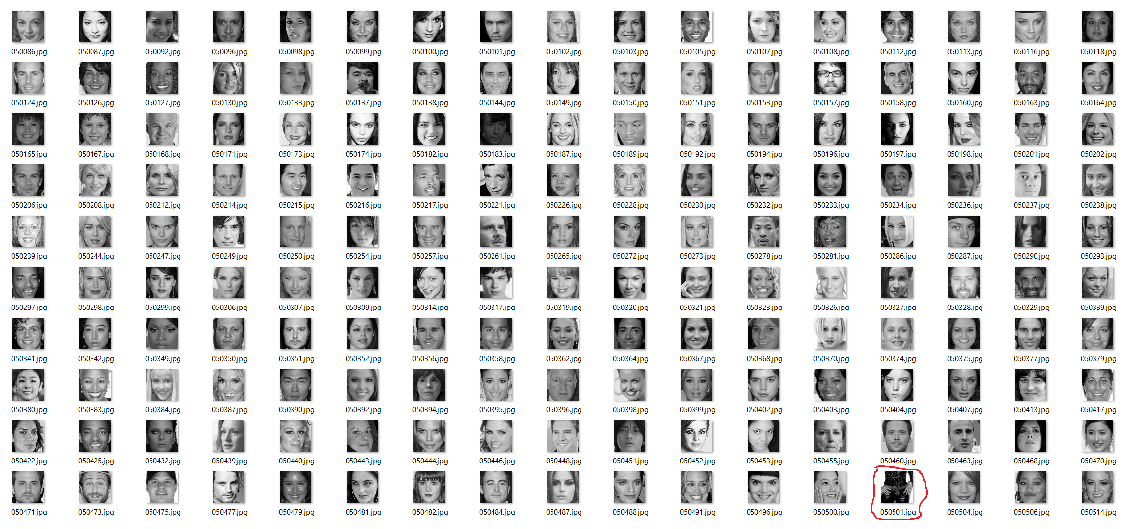

In [5]:
img = cv2.cvtColor(cv2.imread('faceExam.png'), cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,40))
plt.axis('off')
plt.imshow(img);

There are many false negatives (nearly 60% of images), but we have data in abundance, so it is not a problem. Do note, however, that there is an advantage to the rigorous normalization process; the number of false positives is extremely low, thereby making the manual inspection and cleaning of the resultant images much easier. In fact, we might as well forgo this step.

# Any feedback on our goals\work so far would be very welcome!